### Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotNormal
import random

In [14]:
# Plot function

def plot_feature(dataset:pd.DataFrame, featureName:str):
    
    fig, axs = plt.subplots(1, 1, figsize=(20, 10))

    dataset[['date_forecast', featureName]].set_index("date_forecast").plot(ax=axs, title=featureName, color='red')

# Data preperation

In [15]:
# Read and unpack data
data_test_ALL = pd.read_csv("current_csv_files/data_test_ALL.csv")
data_test_ALL = data_test_ALL.sort_values(['date_forecast', 'A', 'B', 'C'], ascending=[True, False, False, False])
data_test_ALL = data_test_ALL.set_index('date_forecast')

data_ALL = data_test_ALL[data_test_ALL['train'] == 1]
test_ALL = data_test_ALL[data_test_ALL['train'] == 0].drop('pv_measurement', axis='columns')

# Rename to target. Ignore warning
data_ALL.rename(columns={'pv_measurement': 'target'}, inplace=True)

/var/folders/kq/hk1l39ys077bc7f9741ypg800000gn/T/ipykernel_1587/1760621836.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ALL.rename(columns={'pv_measurement': 'target'}, inplace=True)


In [4]:

#data_ALL = pd.read_csv("current_csv_files/data_ALL.csv", index_col='date_forecast')
#test_ALL = pd.read_csv("current_csv_files/test_ALL.csv", index_col='date_forecast')

In [5]:
# Separate features and target variable
X = data_ALL.drop('target', axis='columns')
y = data_ALL['target']



"""
X_A = X[ X['A'] == 1 ]
X_B = X[ X['B'] == 1 ]
X_C = X[ X['C'] == 1 ]

y_A = data_ALL[ data_ALL['A'] == 1 ]['target']
y_B = data_ALL[ data_ALL['B'] == 1 ]['target']
y_C = data_ALL[ data_ALL['C'] == 1 ]['target']

data_sets = [X_A, X_B, X_C, y_A, y_B, y_C]
"""


"\nX_A = X[ X['A'] == 1 ]\nX_B = X[ X['B'] == 1 ]\nX_C = X[ X['C'] == 1 ]\n\ny_A = data_ALL[ data_ALL['A'] == 1 ]['target']\ny_B = data_ALL[ data_ALL['B'] == 1 ]['target']\ny_C = data_ALL[ data_ALL['C'] == 1 ]['target']\n\ndata_sets = [X_A, X_B, X_C, y_A, y_B, y_C]\n"

In [79]:
"""
# Create val and test sets

def split_data(df, percent):
    split_index = int( np.floor( len(df)*percent ) )
    df_first = df[:split_index]
    df_last = df[split_index:]
    return df_first, df_last

val_percent = 0.8 # Of all
test_percent = 0.5 # Of val

train_set = []
non_train_set = []
val_set = []
test_set = []

for data in data_sets:
    train, non_train = split_data(data, val_percent)
    train_set.append(train)
    non_train_set.append(non_train)

for non_train in non_train_set:
    val, test = split_data(non_train, test_percent)
    val_set.append(val)
    test_set.append(test)

X_train = pd.concat([ train_set[0], train_set[1], train_set[2] ], ignore_index=False)
y_train = pd.concat([ train_set[3], train_set[4], train_set[5] ], ignore_index=False)

X_val = pd.concat([ val_set[0], val_set[1], val_set[2] ], ignore_index=False)
y_val = pd.concat([ val_set[3], val_set[4], val_set[5] ], ignore_index=False)

X_test = pd.concat([ test_set[0], test_set[1], test_set[2] ], ignore_index=False)
y_test = pd.concat([ test_set[3], test_set[4], test_set[5] ], ignore_index=False)
"""

'\n# Create val and test sets\n\ndef split_data(df, percent):\n    split_index = int( np.floor( len(df)*percent ) )\n    df_first = df[:split_index]\n    df_last = df[split_index:]\n    return df_first, df_last\n\nval_percent = 0.8 # Of all\ntest_percent = 0.5 # Of val\n\ntrain_set = []\nnon_train_set = []\nval_set = []\ntest_set = []\n\nfor data in data_sets:\n    train, non_train = split_data(data, val_percent)\n    train_set.append(train)\n    non_train_set.append(non_train)\n\nfor non_train in non_train_set:\n    val, test = split_data(non_train, test_percent)\n    val_set.append(val)\n    test_set.append(test)\n\nX_train = pd.concat([ train_set[0], train_set[1], train_set[2] ], ignore_index=False)\ny_train = pd.concat([ train_set[3], train_set[4], train_set[5] ], ignore_index=False)\n\nX_val = pd.concat([ val_set[0], val_set[1], val_set[2] ], ignore_index=False)\ny_val = pd.concat([ val_set[3], val_set[4], val_set[5] ], ignore_index=False)\n\nX_test = pd.concat([ test_set[0], test

In [17]:
def split_data(df, percent):
    split_index = int( np.floor( len(df)*percent ) )
    df_first = df[:split_index]
    df_last = df[split_index:]
    return df_first, df_last

train_percent = 0.88 # Of all
val_percent = 0.5 # Of non-train

X_train, X_non_train = split_data(X, train_percent)
X_val, X_test = split_data(X_non_train, val_percent)

y_train, y_non_train = split_data(y, train_percent)
y_val, y_test = split_data(y_non_train, val_percent)



In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_non_train = scaler.fit_transform(X_non_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [53]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Model training

In [18]:
class CustomModelCheckpoint(Callback):
    def __init__(self, best_weights, i):
        self.best_weights = best_weights  # Dictionary to store best weights
        self.best_loss = np.inf
        self.model_index = i  # Index to handle the specific model in the list

    def on_epoch_end(self, epoch, logs=None):
        # Monitor the validation loss
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best_loss:
            # Update the best loss and best weights
            self.best_loss = current_val_loss
            self.best_weights[self.model_index] = self.model.get_weights()

[34, 67, 62, 87, 59, 90]
Epoch 1/100
2557/2557 [==============================] - 3s 1ms/step - loss: 110.1104 - val_loss: 355.3897
Epoch 2/100
2557/2557 [==============================] - 2s 942us/step - loss: 93.6069 - val_loss: 251.6501
Epoch 3/100
2557/2557 [==============================] - 2s 905us/step - loss: 90.7960 - val_loss: 285.9292
Epoch 4/100
2557/2557 [==============================] - 3s 1ms/step - loss: 89.0341 - val_loss: 306.3253
Epoch 5/100
2557/2557 [==============================] - 2s 938us/step - loss: 87.2881 - val_loss: 199.9153
Epoch 6/100
2557/2557 [==============================] - 3s 978us/step - loss: 86.8636 - val_loss: 226.7191
Epoch 7/100
2557/2557 [==============================] - 2s 893us/step - loss: 85.2684 - val_loss: 166.3464
Epoch 8/100
2557/2557 [==============================] - 2s 944us/step - loss: 84.0908 - val_loss: 159.0531
Epoch 9/100
2557/2557 [==============================] - 2s 934us/step - loss: 82.9193 - val_loss: 253.0165
Epoch 

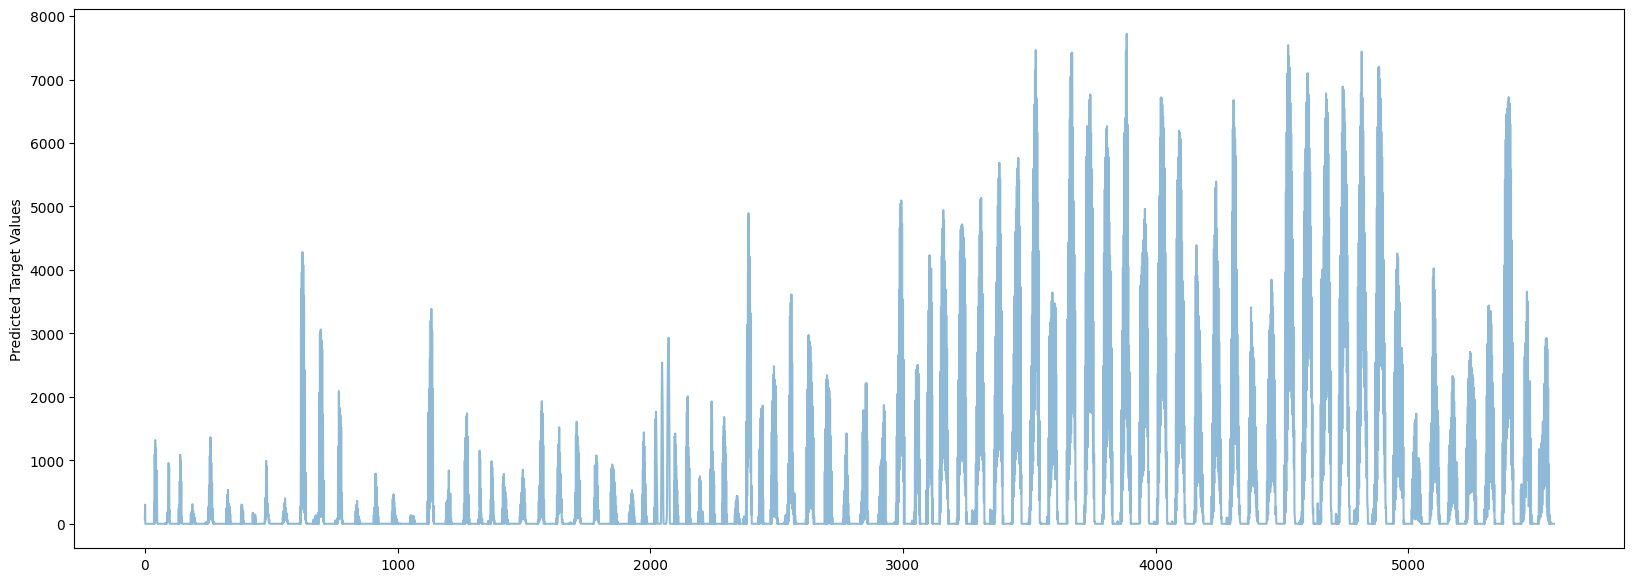

Epoch 1/100
2557/2557 [==============================] - 3s 937us/step - loss: 108.8181 - val_loss: 391.9708
Epoch 2/100
2557/2557 [==============================] - 2s 890us/step - loss: 93.3159 - val_loss: 368.5684
Epoch 3/100
2557/2557 [==============================] - 2s 889us/step - loss: 90.6201 - val_loss: 280.6082
Epoch 4/100
2557/2557 [==============================] - 2s 875us/step - loss: 89.2851 - val_loss: 191.5378
Epoch 5/100
2557/2557 [==============================] - 2s 898us/step - loss: 87.2891 - val_loss: 202.2788
Epoch 6/100
2557/2557 [==============================] - 2s 894us/step - loss: 85.8497 - val_loss: 196.0330
Epoch 7/100
2557/2557 [==============================] - 2s 915us/step - loss: 84.8941 - val_loss: 102.0844
Epoch 8/100
2557/2557 [==============================] - 2s 907us/step - loss: 83.7892 - val_loss: 187.3579
Epoch 9/100
2557/2557 [==============================] - 2s 901us/step - loss: 82.9369 - val_loss: 185.0018
Epoch 10/100
2557/2557 [===

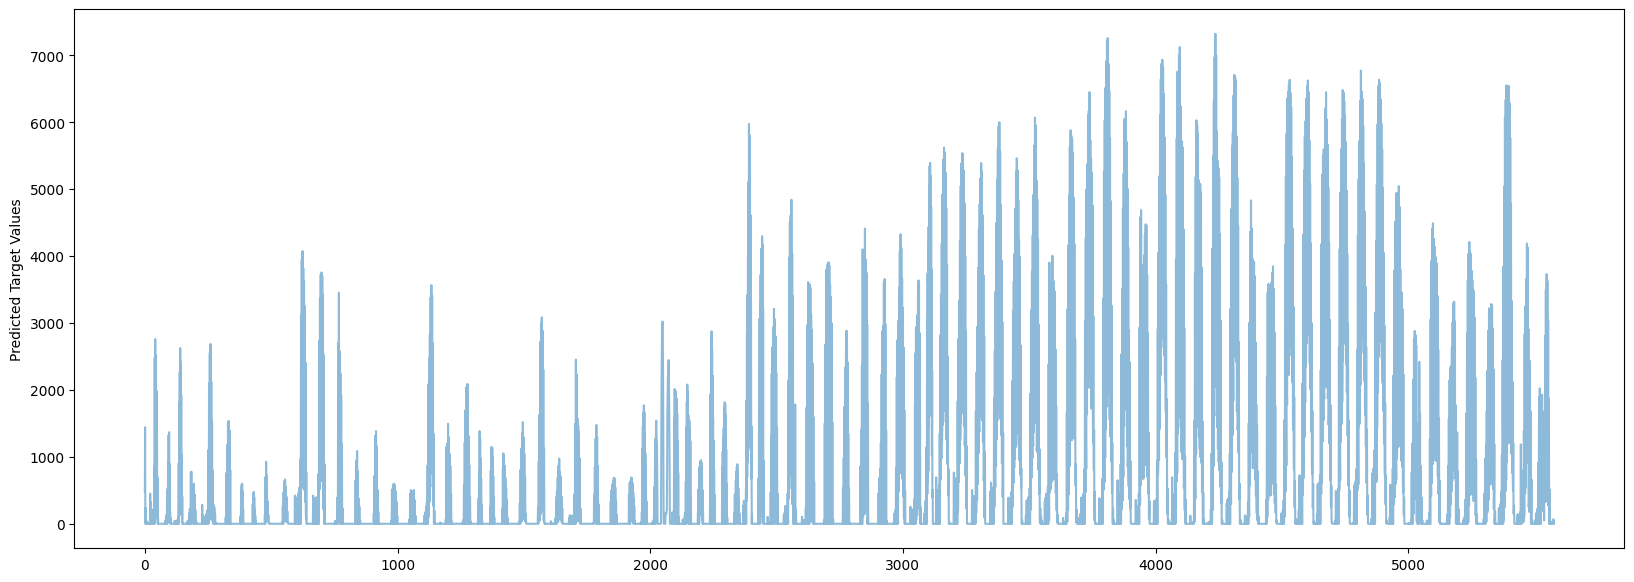

Epoch 1/100
2557/2557 [==============================] - 3s 950us/step - loss: 109.1774 - val_loss: 292.1913
Epoch 2/100
2557/2557 [==============================] - 2s 925us/step - loss: 92.8286 - val_loss: 312.7883
Epoch 3/100
2557/2557 [==============================] - 2s 965us/step - loss: 90.8510 - val_loss: 145.8416
Epoch 4/100
2557/2557 [==============================] - 3s 978us/step - loss: 88.8588 - val_loss: 94.6515
Epoch 5/100
2557/2557 [==============================] - 2s 944us/step - loss: 87.7385 - val_loss: 170.5645
Epoch 6/100
2557/2557 [==============================] - 2s 915us/step - loss: 86.4252 - val_loss: 129.2395
Epoch 7/100
2557/2557 [==============================] - 2s 892us/step - loss: 85.1139 - val_loss: 151.8157
Epoch 8/100
2557/2557 [==============================] - 2s 964us/step - loss: 83.8427 - val_loss: 132.5436
Epoch 9/100
2526/2557 [============================>.] - ETA: 0s - loss: 82.9071

KeyboardInterrupt: 

In [20]:
seeds = [ random.randint(0, 100) for _ in range(6) ]
#seeds = [23, 34, 23, 60, 68, 78]
inits = [ HeNormal(seed=s) for s in seeds ]
print(seeds)

N = 10
nets = []

# Initialize dictionary to store the best weights for each model
best_weights_during_training = {}

for i in range(N):
    # Define the Keras model
    model = Sequential([
        Dense(128, input_dim=X_train.shape[1], activation='tanh', kernel_initializer=inits[0]),
        #Dropout(0.2, (150,), seed=seeds[5]),
        Dense(256, activation='relu', kernel_initializer=inits[1]),
        #Dense(120, activation='relu', kernel_initializer=inits[2], kernel_regularizer=l2(0.05)),
        Dense(128, activation='relu', kernel_initializer=inits[2]),
        Dense(64, activation='relu', kernel_initializer=inits[3]),
        Dense(1, activation='relu', kernel_initializer=inits[4])
    ])
    nets.append(model)

    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=opt)

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1, patience=10)

    # Create an instance of the custom checkpoint for the current model
    custom_checkpoint = CustomModelCheckpoint(best_weights_during_training, i)

    # Fit the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        #validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping, custom_checkpoint]
    )

    # Store the best weights for the current model
    if i not in best_weights_during_training:
        # If the model didn't improve, just save the last weights
        best_weights_during_training[i] = model.get_weights()

    prediction = model.predict(X_test)
    print(i, " MAE: ", mean_absolute_error(prediction, y_test))
    # Plot pred
    
    plt.figure(figsize=(20, 7))
    plt.plot(prediction, alpha=0.5)
    plt.ylabel('Predicted Target Values')
    plt.show()
    

    

# Making prediction

In [26]:
# Make predictions using the best test validation epoch
best_preds = []

for i in range(N):
    nets[i].set_weights(best_weights_during_training[i])
    best_preds.append(nets[i].predict(X_train_est_scaled).ravel()) # Select dataset of choice
    print(i, "MAE: ", mean_absolute_error(y_train_est, best_preds[i]))

345/345 [==============================] - 0s 375us/step
0 MAE:  90.42444382596193
345/345 [==============================] - 0s 397us/step
1 MAE:  85.87556676845726
345/345 [==============================] - 0s 356us/step
2 MAE:  82.86574777188432
345/345 [==============================] - 0s 349us/step
3 MAE:  81.15528315744787
345/345 [==============================] - 0s 358us/step
4 MAE:  85.02020008993175
345/345 [==============================] - 0s 348us/step
5 MAE:  85.24118838279912
345/345 [==============================] - 0s 352us/step
6 MAE:  88.59880382468266
345/345 [==============================] - 0s 382us/step
7 MAE:  84.75789449582233
345/345 [==============================] - 0s 373us/step
8 MAE:  82.49380306568746
345/345 [==============================] - 0s 379us/step
9 MAE:  87.99493158434223


In [31]:
# Create dataframe
df_best_preds = pd.DataFrame(best_preds).T

df_best_preds['avg'] = df_best_preds.mean(axis='columns')

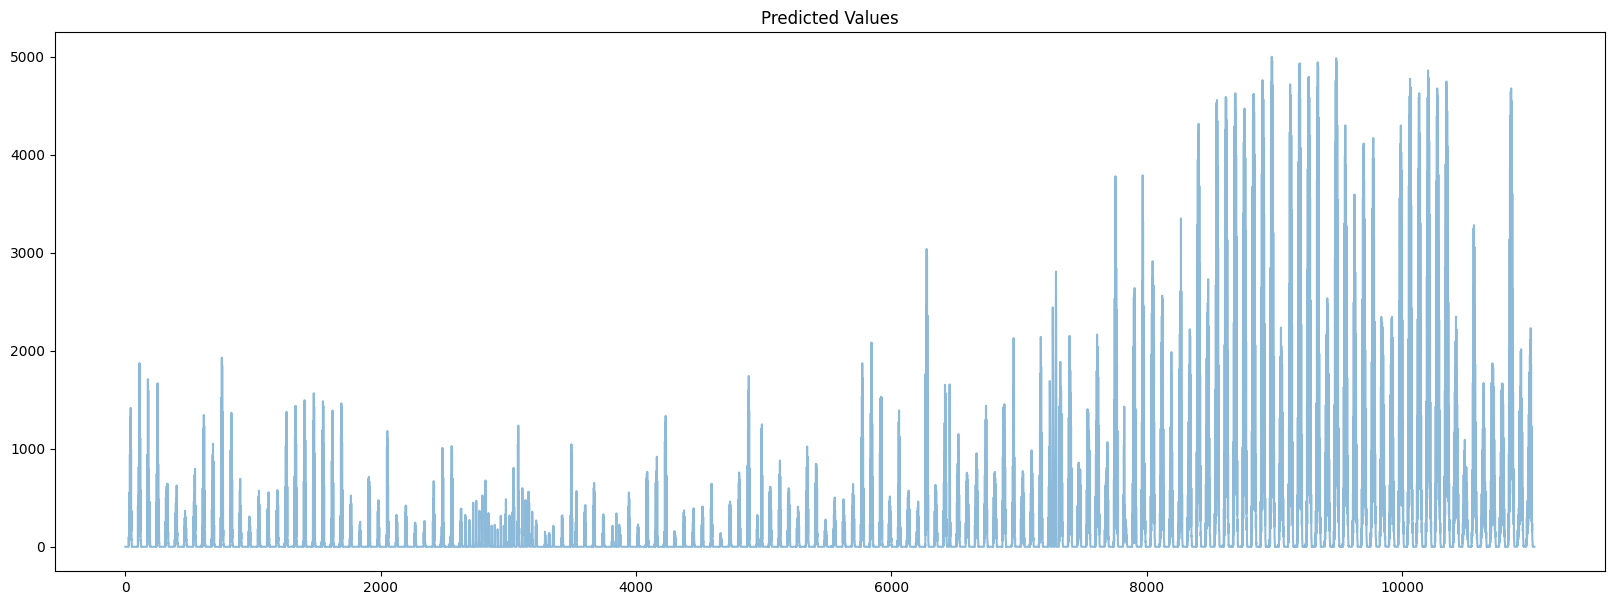

In [32]:
plt.figure(figsize=(20, 7))
plt.plot(df_best_preds['avg'], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [28]:
from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(df_best_preds.iloc[: , :N], y_train_est) # Select dataset of choice

LinearRegression()

In [34]:
print("MAE: ", mean_absolute_error(y_train_est, df_best_preds['avg']))

MAE:  83.69711392474223


In [35]:
# Make kaggle prediction
best_kaggle_preds = []

for i in range(N):
    best_kaggle_preds.append(nets[i].predict(X_kaggle).ravel())
    # TODO: test against best sub    print(i, "MAE: ", mean_absolute_error(y_val_test, best_preds[i]))

68/68 [==============================] - 0s 575us/step


In [46]:
# Create dataframe for kaggle pred
df_kaggle_preds = pd.DataFrame(best_kaggle_preds).T

#df_kaggle_preds['avg'] = df_kaggle_preds.mean(axis='columns')

kaggle_pred = LR_model.predict(df_kaggle_preds.iloc[: , :N])
kaggle_pred = kaggle_pred.clip(min=0)

In [47]:
# Merge with kaggle_test data and sort after date_forecast
test_ALL_to_sub = pd.read_csv("current_csv_files/test_ALL.csv")
test_ALL_to_sub['prediction'] = kaggle_pred

#test_ALL_to_sub['avg'] = df_kaggle_preds['avg']

In [48]:
# Correctly sort test data for submission
test_ALL_sorted = test_ALL_to_sub.sort_values(['A', 'B', 'C', 'date_forecast'], ascending=[False, False, False, True])
test_ALL_sorted['id'] = range(2160)

In [3]:
# Read sub4
sub4 = pd.read_csv("teo_subs/teo_sub_4.csv", index_col='id')

MAE:  158.0658907206313


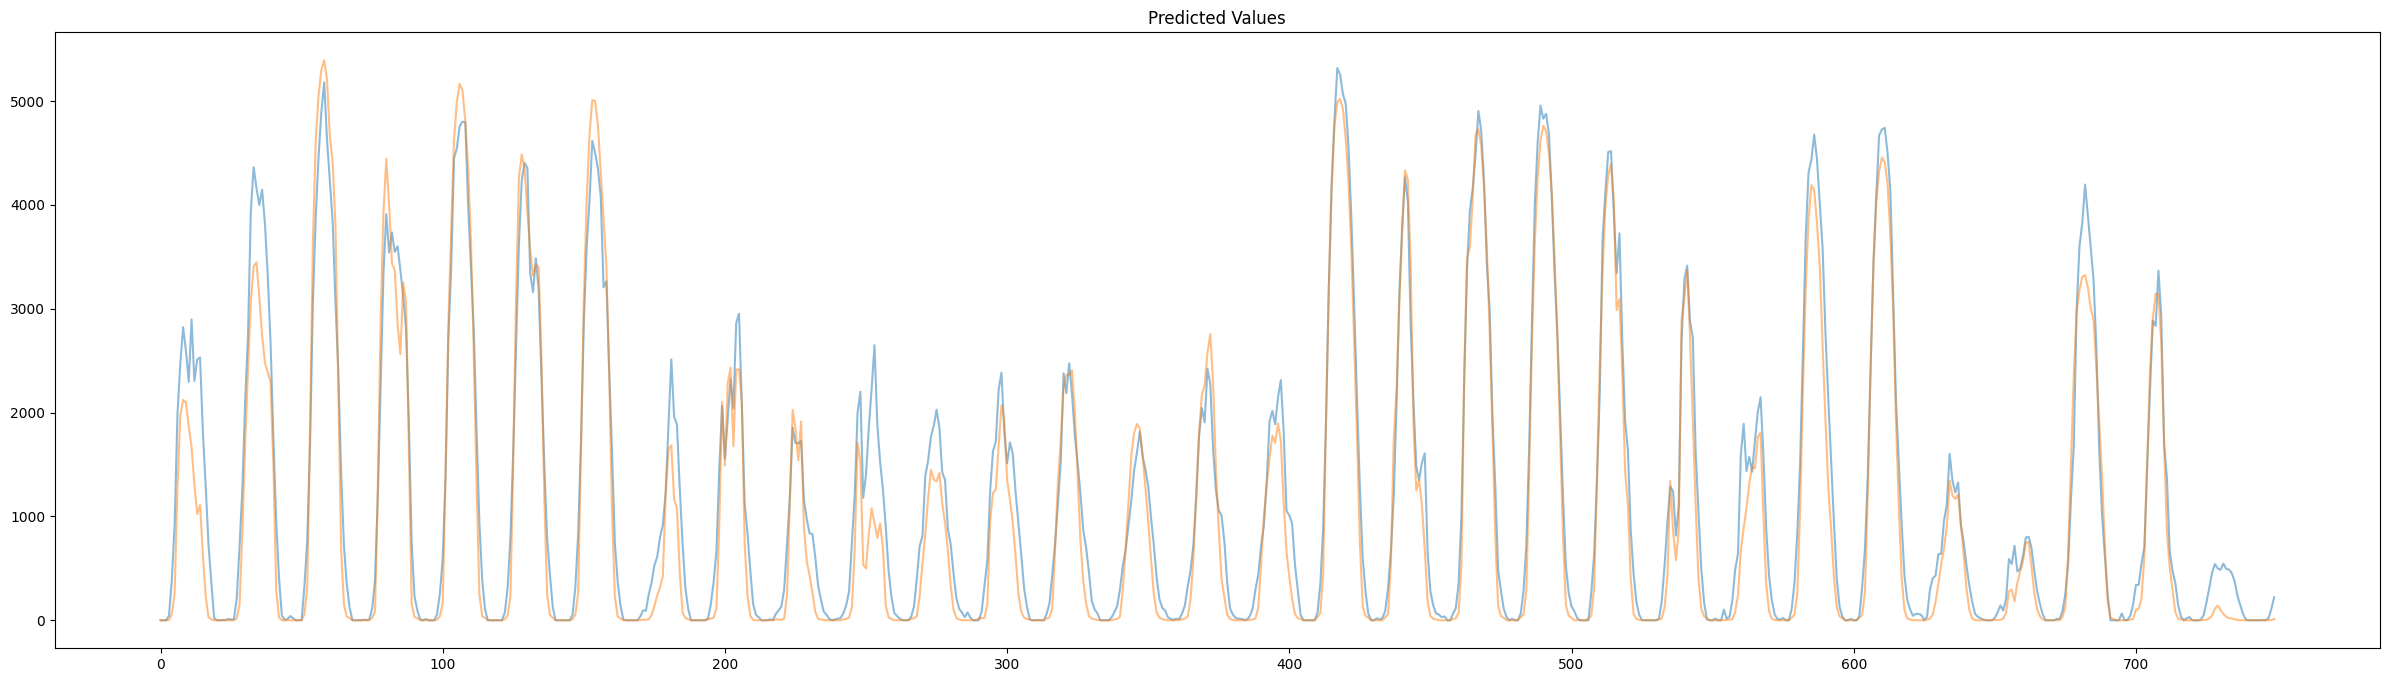

In [9]:
# Comparison to best sub on kaggle

best_sub = pd.read_csv("teo_subs/best_sub.csv", index_col='id')
print("MAE: ", mean_absolute_error(best_sub, sub4))

slide = 0
start = 0 + slide
stop = 750 + slide

plt.figure(figsize=(30, 8))
plt.plot(range(start, stop), best_sub.iloc[start:stop], alpha=0.5)
plt.plot(range(start, stop), sub4.iloc[start:stop], alpha=0.5)
plt.title('Predicted Values')
plt.show()

In [50]:
test_ALL_sorted[['id', 'prediction']].to_csv("teo_subs/teo_sub_5.csv", index=False)